In [14]:
!pip install -q pandas matplotlib

import os, zipfile, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 50)

from google.colab import files


In [15]:
print("👉 Please upload your archive.zip file containing the dataset")
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]
extract_path = "./olympics_data"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(extract_path)

print("✅ Extracted files:")
for root, _, files in os.walk(extract_path):
    for f in files:
        if f.lower().endswith(".csv"):
            print(os.path.join(root, f))


👉 Please upload your archive.zip file containing the dataset


Saving archive.zip to archive (1).zip
✅ Extracted files:
./olympics_data/SaltLakeCity 2002 Olympics Nations Medals.csv
./olympics_data/Athens 2004 Olympics Nations Medals.csv
./olympics_data/Atlanta 1996 Olympics Nations Medals.csv
./olympics_data/Torino 2006 Olympics Nations Medals.csv
./olympics_data/Sochi 2014 Olympics Nations Medals.csv
./olympics_data/PyeongChang 2018 Olympics Nations Medals.csv
./olympics_data/Beijing_2008_ Olympics_Nations_Medals.csv
./olympics_data/Lillehammer 1994 Olympics Nations Medals.csv
./olympics_data/Tokyo 2020 Olympics Nations Medals.csv
./olympics_data/Vancouver 2010 Olympics Nations Medals.csv
./olympics_data/beijing_2022_Olympics_Nations_Medals.csv
./olympics_data/London 2012 Olympics Nations Medals.csv
./olympics_data/Paris 2024 Olympics_Nations Medals.csv
./olympics_data/Nagano 1998 Olympics Nations Medals.csv
./olympics_data/Sydney 2000 Olympics Nations Medals.csv
./olympics_data/Rio 2016 Olympics Nations Medals.csv


In [16]:
# Prefer athlete_events.csv if it exists
csv_candidates = []
for root, _, files in os.walk(extract_path):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_candidates.append(os.path.join(root, f))

if not csv_candidates:
    raise FileNotFoundError("No CSV file found inside the ZIP.")

preferred = [p for p in csv_candidates if os.path.basename(p).lower() == "athlete_events.csv"]
file_path = preferred[0] if preferred else csv_candidates[0]

print(f"\n📄 Using CSV: {file_path}")
df = pd.read_csv(file_path, low_memory=False)

print("📌 Columns in dataset:", df.columns.tolist())
print("\n📊 First 5 rows:")
print(df.head(5))
print("Shape:", df.shape)



📄 Using CSV: ./olympics_data/SaltLakeCity 2002 Olympics Nations Medals.csv
📌 Columns in dataset: ['NOC', 'Gold', 'Silver', 'Bronze', 'Total']

📊 First 5 rows:
   NOC  Gold  Silver  Bronze  Total
0  NOR    13       5       7     25
1  GER    12      16       8     36
2  USA    10      13      11     34
3  CAN     7       3       7     17
4  RUS     5       4       4     13
Shape: (24, 5)


In [18]:
# --- Clean & Standardize Medal Tally Dataset ---
df2 = df.copy()

# Ensure medal columns exist
for col in ["Gold", "Silver", "Bronze", "Total"]:
    if col not in df2.columns:
        raise ValueError(f"❌ Missing {col} column in dataset!")

# Standardize Team column name
if "Team" not in df2.columns:
    for alt in ["NOC", "Country", "region", "Nation"]:
        if alt in df2.columns:
            df2 = df2.rename(columns={alt: "Team"})
            break

print("✅ Standardized columns:", df2.columns.tolist())

# --- Create SQLite DB ---
conn = sqlite3.connect(":memory:")
df2.to_sql("medals", conn, if_exists="replace", index=False)

def run_sql(q):
    return pd.read_sql(q, conn)

print("✅ medals table created. Rows:", len(df2))
print(run_sql("SELECT * FROM medals LIMIT 5;"))



✅ Standardized columns: ['Team', 'Gold', 'Silver', 'Bronze', 'Total']
✅ medals table created. Rows: 24
  Team  Gold  Silver  Bronze  Total
0  NOR    13       5       7     25
1  GER    12      16       8     36
2  USA    10      13      11     34
3  CAN     7       3       7     17
4  RUS     5       4       4     13


In [19]:
print("📌 FINAL columns:", df2.columns.tolist())
print("\n🔎 Sample 10 rows after cleaning:")
print(df2.head(10).to_string())

print("\n✅ Example rows from SQL:")
print(run_sql("SELECT Team, Gold, Silver, Bronze, Total FROM medals LIMIT 10;"))


📌 FINAL columns: ['Team', 'Gold', 'Silver', 'Bronze', 'Total']

🔎 Sample 10 rows after cleaning:
  Team  Gold  Silver  Bronze  Total
0  NOR    13       5       7     25
1  GER    12      16       8     36
2  USA    10      13      11     34
3  CAN     7       3       7     17
4  RUS     5       4       4     13
5  FRA     4       5       2     11
6  ITA     4       4       5     13
7  FIN     4       2       1      7
8  NED     3       5       0      8
9  AUT     3       4      10     17

✅ Example rows from SQL:
  Team  Gold  Silver  Bronze  Total
0  NOR    13       5       7     25
1  GER    12      16       8     36
2  USA    10      13      11     34
3  CAN     7       3       7     17
4  RUS     5       4       4     13
5  FRA     4       5       2     11
6  ITA     4       4       5     13
7  FIN     4       2       1      7
8  NED     3       5       0      8
9  AUT     3       4      10     17


  Team  Total
0  GER     36
1  USA     34
2  NOR     25
3  CAN     17
4  AUT     17
5  RUS     13
6  ITA     13
7  FRA     11
8  SUI     11
9  NED      8
  Team  Gold
0  NOR    13
1  GER    12
2  USA    10
3  CAN     7
4  RUS     5
5  FRA     4
6  ITA     4
7  FIN     4
8  NED     3
9  AUT     3


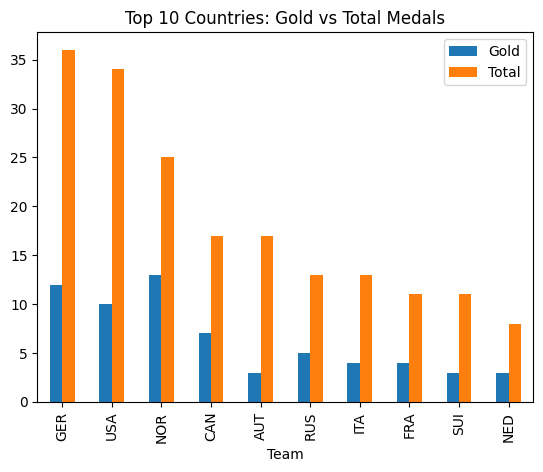

  Team  share_percent
0  GER          15.38
1  USA          14.53
2  NOR          10.68
3  CAN           7.26
4  AUT           7.26
5  RUS           5.56
6  ITA           5.56
7  FRA           4.70
8  SUI           4.70
9  NED           3.42


In [20]:
# 1. Top 10 countries by total medals
print(run_sql("""
    SELECT Team, Total
    FROM medals
    ORDER BY Total DESC
    LIMIT 10;
"""))

# 2. Top 10 countries by Gold medals
print(run_sql("""
    SELECT Team, Gold
    FROM medals
    ORDER BY Gold DESC
    LIMIT 10;
"""))

# 3. Gold vs Total plot
medals_plot = run_sql("SELECT Team, Gold, Total FROM medals ORDER BY Total DESC LIMIT 10;")
medals_plot.plot(x="Team", y=["Gold","Total"], kind="bar")
plt.title("Top 10 Countries: Gold vs Total Medals")
plt.show()

# 4. Medal share (%) of each country
share = run_sql("""
    SELECT Team,
           ROUND(100.0*Total/(SELECT SUM(Total) FROM medals),2) AS share_percent
    FROM medals
    ORDER BY share_percent DESC
    LIMIT 10;
""")
print(share)


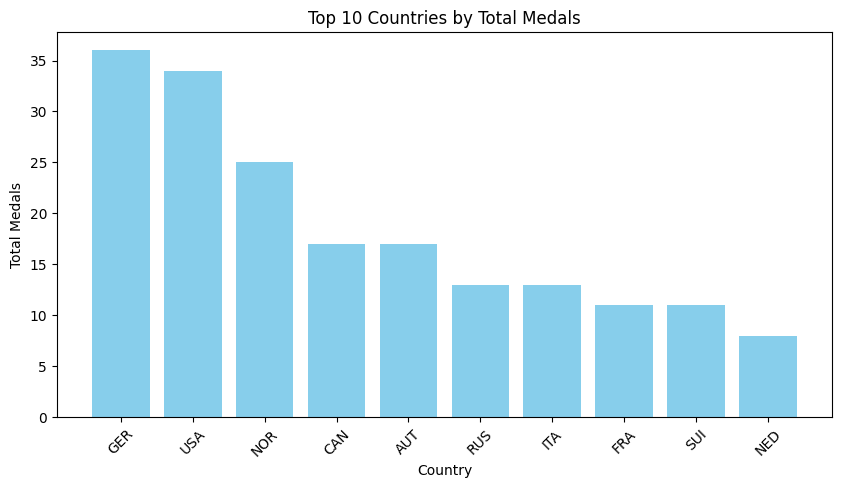

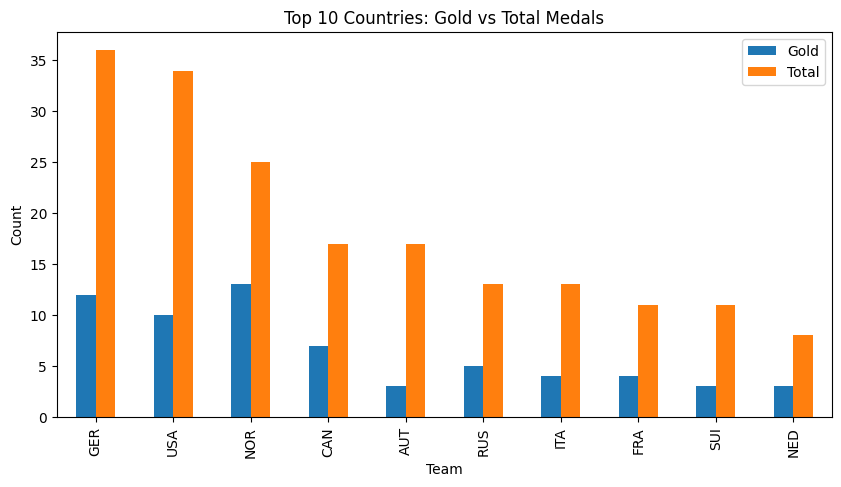

In [21]:
# Plot top 10 by TOTAL medals
top_total = run_sql("SELECT Team, Total FROM medals ORDER BY Total DESC LIMIT 10;")

plt.figure(figsize=(10,5))
plt.bar(top_total["Team"], top_total["Total"], color="skyblue")
plt.title("Top 10 Countries by Total Medals")
plt.xlabel("Country")
plt.ylabel("Total Medals")
plt.xticks(rotation=45)
plt.show()

# Plot Gold vs Total for top 10
medals_plot = run_sql("SELECT Team, Gold, Total FROM medals ORDER BY Total DESC LIMIT 10;")

medals_plot.plot(x="Team", y=["Gold","Total"], kind="bar", figsize=(10,5))
plt.title("Top 10 Countries: Gold vs Total Medals")
plt.ylabel("Count")
plt.show()


🌍 Share of medals (Top 10 countries):
  Team  share_percent
0  GER          15.38
1  USA          14.53
2  NOR          10.68
3  CAN           7.26
4  AUT           7.26
5  RUS           5.56
6  ITA           5.56
7  FRA           4.70
8  SUI           4.70
9  NED           3.42


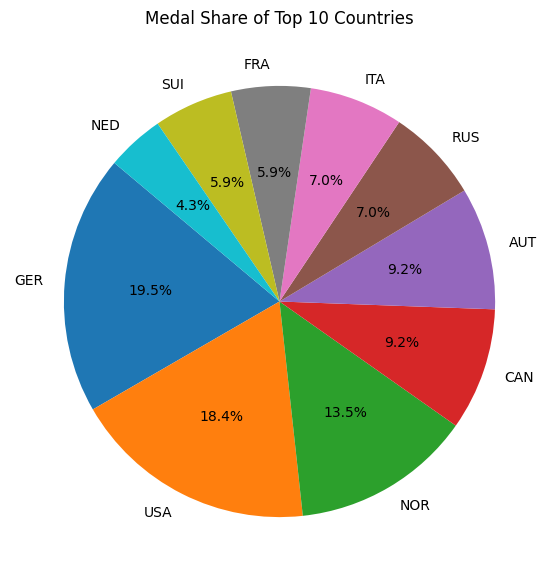

In [22]:
# Medal share of top 10 countries
share = run_sql("""
    SELECT Team,
           ROUND(100.0*Total/(SELECT SUM(Total) FROM medals),2) AS share_percent
    FROM medals
    ORDER BY share_percent DESC
    LIMIT 10;
""")

print("🌍 Share of medals (Top 10 countries):")
print(share)

# Pie chart for medal share
plt.figure(figsize=(7,7))
plt.pie(share["share_percent"], labels=share["Team"], autopct='%1.1f%%', startangle=140)
plt.title("Medal Share of Top 10 Countries")
plt.show()


🔎 Countries with highest Gold-to-Total ratio:
  Team  Gold  Total  gold_ratio
0  AUS     2      2        1.00
1  CRO     3      4        0.75
2  FIN     4      7        0.57
3  NOR    13     25        0.52
4  KOR     2      4        0.50
5  GBR     1      2        0.50
6  CAN     7     17        0.41
7  RUS     5     13        0.38
8  NED     3      8        0.38
9  FRA     4     11        0.36


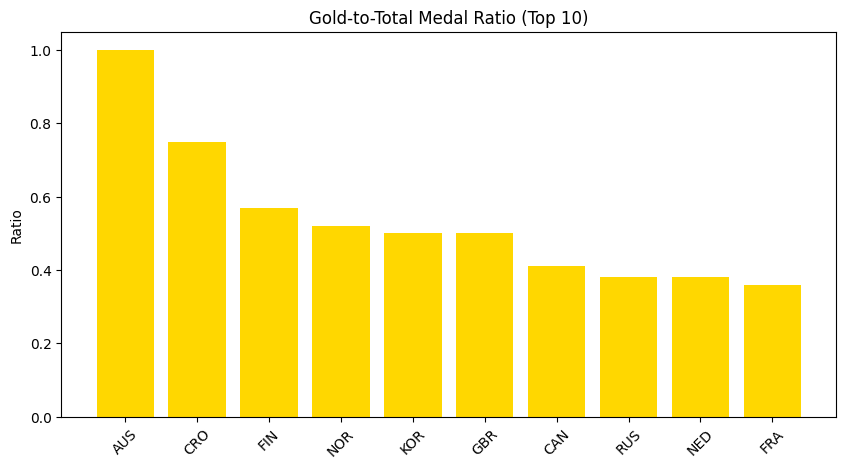

In [23]:
# Gold-to-Total ratio
ratio = run_sql("""
    SELECT Team,
           Gold,
           Total,
           ROUND(1.0*Gold/Total, 2) AS gold_ratio
    FROM medals
    WHERE Total > 0
    ORDER BY gold_ratio DESC
    LIMIT 10;
""")

print("🔎 Countries with highest Gold-to-Total ratio:")
print(ratio)

# Plot ratio
plt.figure(figsize=(10,5))
plt.bar(ratio["Team"], ratio["gold_ratio"], color="gold")
plt.title("Gold-to-Total Medal Ratio (Top 10)")
plt.ylabel("Ratio")
plt.xticks(rotation=45)
plt.show()


In [24]:
# Overall medal counts
summary = run_sql("""
    SELECT SUM(Gold) AS Total_Gold,
           SUM(Silver) AS Total_Silver,
           SUM(Bronze) AS Total_Bronze,
           SUM(Total) AS Grand_Total
    FROM medals;
""")

print("📊 Overall Medal Summary:")
print(summary)

# Correlation check between Gold, Silver, Bronze, Total
print("\n📈 Correlation Matrix:")
print(df2[["Gold","Silver","Bronze","Total"]].corr())


📊 Overall Medal Summary:
   Total_Gold  Total_Silver  Total_Bronze  Grand_Total
0          80            76            78          234

📈 Correlation Matrix:
            Gold    Silver    Bronze     Total
Gold    1.000000  0.800011  0.676970  0.920050
Silver  0.800011  1.000000  0.674236  0.922120
Bronze  0.676970  0.674236  1.000000  0.859503
Total   0.920050  0.922120  0.859503  1.000000


🇮🇳 India's Medal Tally:
Empty DataFrame
Columns: [Team, Gold, Silver, Bronze, Total]
Index: []


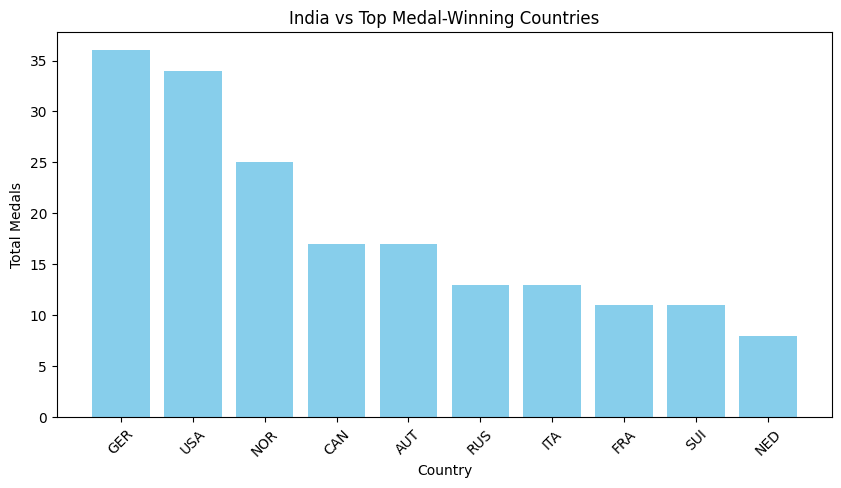

In [25]:
# India’s medal tally
india = run_sql("""
    SELECT Team, Gold, Silver, Bronze, Total
    FROM medals
    WHERE Team = 'IND';
""")

print("🇮🇳 India's Medal Tally:")
print(india)

# Compare India vs Top 10
compare = run_sql("""
    SELECT Team, Total
    FROM medals
    ORDER BY Total DESC
    LIMIT 10;
""")

compare = pd.concat([compare, india], ignore_index=True).drop_duplicates(subset=["Team"])

plt.figure(figsize=(10,5))
plt.bar(compare["Team"], compare["Total"], color=["skyblue" if t!="IND" else "orange" for t in compare["Team"]])
plt.title("India vs Top Medal-Winning Countries")
plt.xlabel("Country")
plt.ylabel("Total Medals")
plt.xticks(rotation=45)
plt.show()


In [26]:
# India ka record check karo
india_check = run_sql("SELECT * FROM medals WHERE Team = 'IND';")
print("🇮🇳 India's row from dataset:")
print(india_check)


🇮🇳 India's row from dataset:
Empty DataFrame
Columns: [Team, Gold, Silver, Bronze, Total]
Index: []


Total countries in dataset: 24
  Team  Gold  Silver  Bronze  Total
0  GER    12      16       8     36
1  USA    10      13      11     34
2  NOR    13       5       7     25
3  CAN     7       3       7     17
4  AUT     3       4      10     17
5  RUS     5       4       4     13
6  ITA     4       4       5     13
7  FRA     4       5       2     11
8  SUI     3       2       6     11
9  NED     3       5       0      8


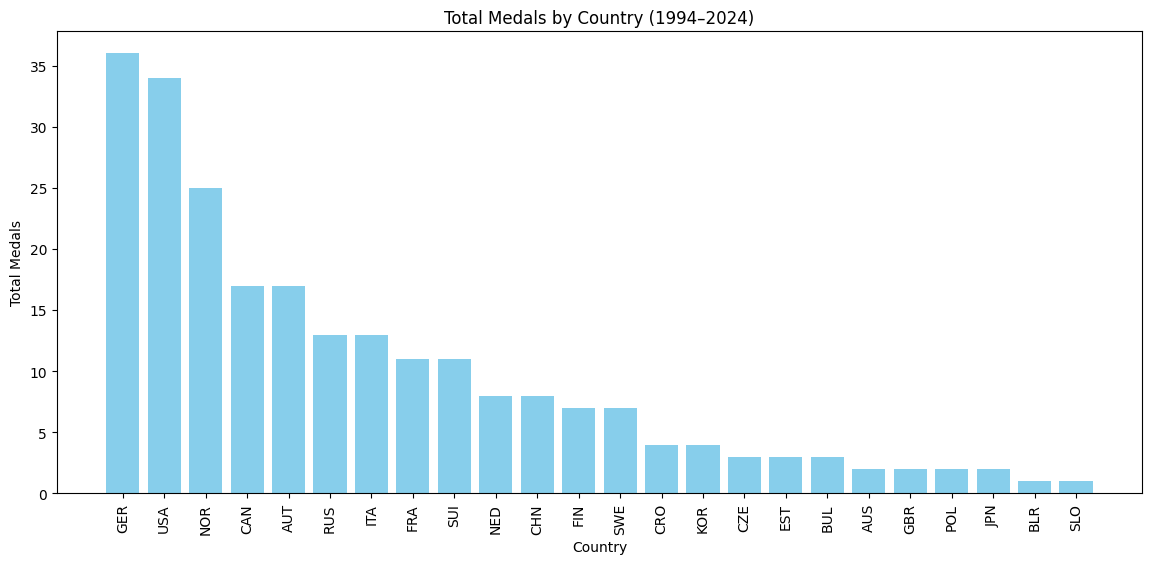

In [29]:
# ✅ All countries medal counts (1994–2024)

query = """
SELECT Team, Gold, Silver, Bronze, Total
FROM medals
ORDER BY Total DESC;
"""
all_countries = run_sql(query)

print("Total countries in dataset:", len(all_countries))
print(all_countries.head(10))  # just to preview

# Plot all countries
plt.figure(figsize=(14,6))
plt.bar(all_countries["Team"], all_countries["Total"], color="skyblue")
plt.xlabel("Country")
plt.ylabel("Total Medals")
plt.title("Total Medals by Country (1994–2024)")
plt.xticks(rotation=90)
plt.show()
